In [14]:
from glob import glob
import pandas as pd
from pingouin import plot_paired, compute_effsize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Read the results generated by OCE.  These were generated by the script oce_model_stats.py

In [15]:
df_list = []
for filename in glob("*SCAF_stats.csv"):
    df = pd.read_csv(filename)
    df_list.append(df)

Concatenate the OCE results into one dataframe.

In [16]:
oce_df = pd.concat(df_list)

Read the results from previous models on this dataset. Note that this file also contains the cross-validation splits.

In [17]:
cmp_df = pd.read_csv("../comparison.csv")

Define the training and test sets.

In [18]:
oce_df['split'] =[f"SCAF_{x:02d}" for x in oce_df.cycle]

Merge oce_df and cmp_df

In [19]:
merge_df = oce_df.merge(cmp_df,on=["dataset","split"])

Compare mean RMSE for 10 folds between OCE and GP

In [20]:
mean_list = []
for k,v in merge_df.groupby("dataset"):
    mean_list.append([k,v.rmse.mean(),v.gp_rmse.mean()])
mean_df = pd.DataFrame(mean_list,columns=["Dataset","OCE RMSE Mean","GP RMSE Mean"])
mean_df.round(2)

,Dataset,OCE RMSE Mean,GP RMSE Mean
0,A2a,1.04,0.95
1,ABL1,0.93,0.89
2,Acetylcholinesterase,0.93,0.94
3,Aurora-A,0.91,0.92
4,B-raf,0.80,0.79
5,COX-1,0.81,0.77
6,COX-2,0.98,0.99
7,Cannabinoid,0.81,0.82
8,Carbonic,0.73,0.73
9,Caspase,0.69,0.68


Plot a kde comparing mean RMSE between GP and OCE

<AxesSubplot:xlabel='RMSE', ylabel='Density'>

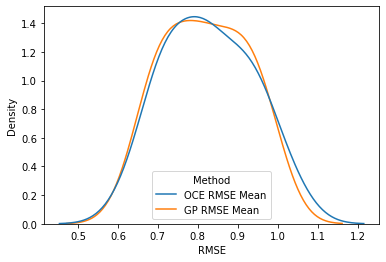

In [21]:
melt_mean_df = mean_df.melt(id_vars="Dataset")
melt_mean_df.columns = ["Dataset","Method","RMSE"]
sns.kdeplot(x="RMSE",hue="Method",data=melt_mean_df)

Calculate the effect size and associated probability

In [22]:
d = compute_effsize(mean_df["OCE RMSE Mean"],mean_df["GP RMSE Mean"],eftype="cohen")
print(f"effect size = {d:.3f}")
print(f"probability = {d*0.25+0.5:.3f}")

effect size = 0.069
probability = 0.517


Look at the merged data

In [23]:
merge_df

,dataset,cycle,r2,rmse,split,gp_r2,xgb_r2,ffnn_r2,gp_rmse,xgb_rmse,ffnn_rmse
0,COX-1,0,0.229054,0.799332,SCAF_00,0.249945,0.060645,-0.005411,0.788427,0.882328,0.912824
1,COX-1,1,0.087400,0.809714,SCAF_01,0.239840,0.107052,-0.025162,0.738999,0.800948,0.858198
2,COX-1,2,0.100981,0.759068,SCAF_02,0.192868,-0.029112,-0.300009,0.719231,0.812134,0.912787
3,COX-1,3,0.223162,0.742356,SCAF_03,0.210598,0.033720,0.029609,0.748336,0.827940,0.829699
4,COX-1,4,0.162866,0.830082,SCAF_04,0.245787,0.191495,0.065660,0.787899,0.815765,0.876953
...,...,...,...,...,...,...,...,...,...,...,...
235,Vanilloid,5,0.405431,0.762618,SCAF_05,0.382155,0.298510,0.300126,0.777402,0.828355,0.827401
236,Vanilloid,6,0.268868,0.720027,SCAF_06,0.254603,0.146642,0.096355,0.727017,0.777887,0.800479
237,Vanilloid,7,0.267001,0.789765,SCAF_07,0.270273,0.150387,0.098509,0.788001,0.850270,0.875845
238,Vanilloid,8,0.308099,0.723293,SCAF_08,0.286852,0.181932,0.158733,0.734315,0.786479,0.797553


Reformat the data to generate the paired plots

In [24]:
melt_df = merge_df[["dataset","cycle","rmse","gp_rmse"]].melt(id_vars=["dataset","cycle"])
melt_df.head()

,dataset,cycle,variable,value
0,COX-1,0,rmse,0.799332
1,COX-1,1,rmse,0.809714
2,COX-1,2,rmse,0.759068
3,COX-1,3,rmse,0.742356
4,COX-1,4,rmse,0.830082


Rename the fields so that plot makes sense

In [25]:
method_dict = {"rmse" : "OCE", "gp_rmse" : "GP"}
melt_df['variable'] = [method_dict[x] for x in melt_df.variable]

Make the paired plots

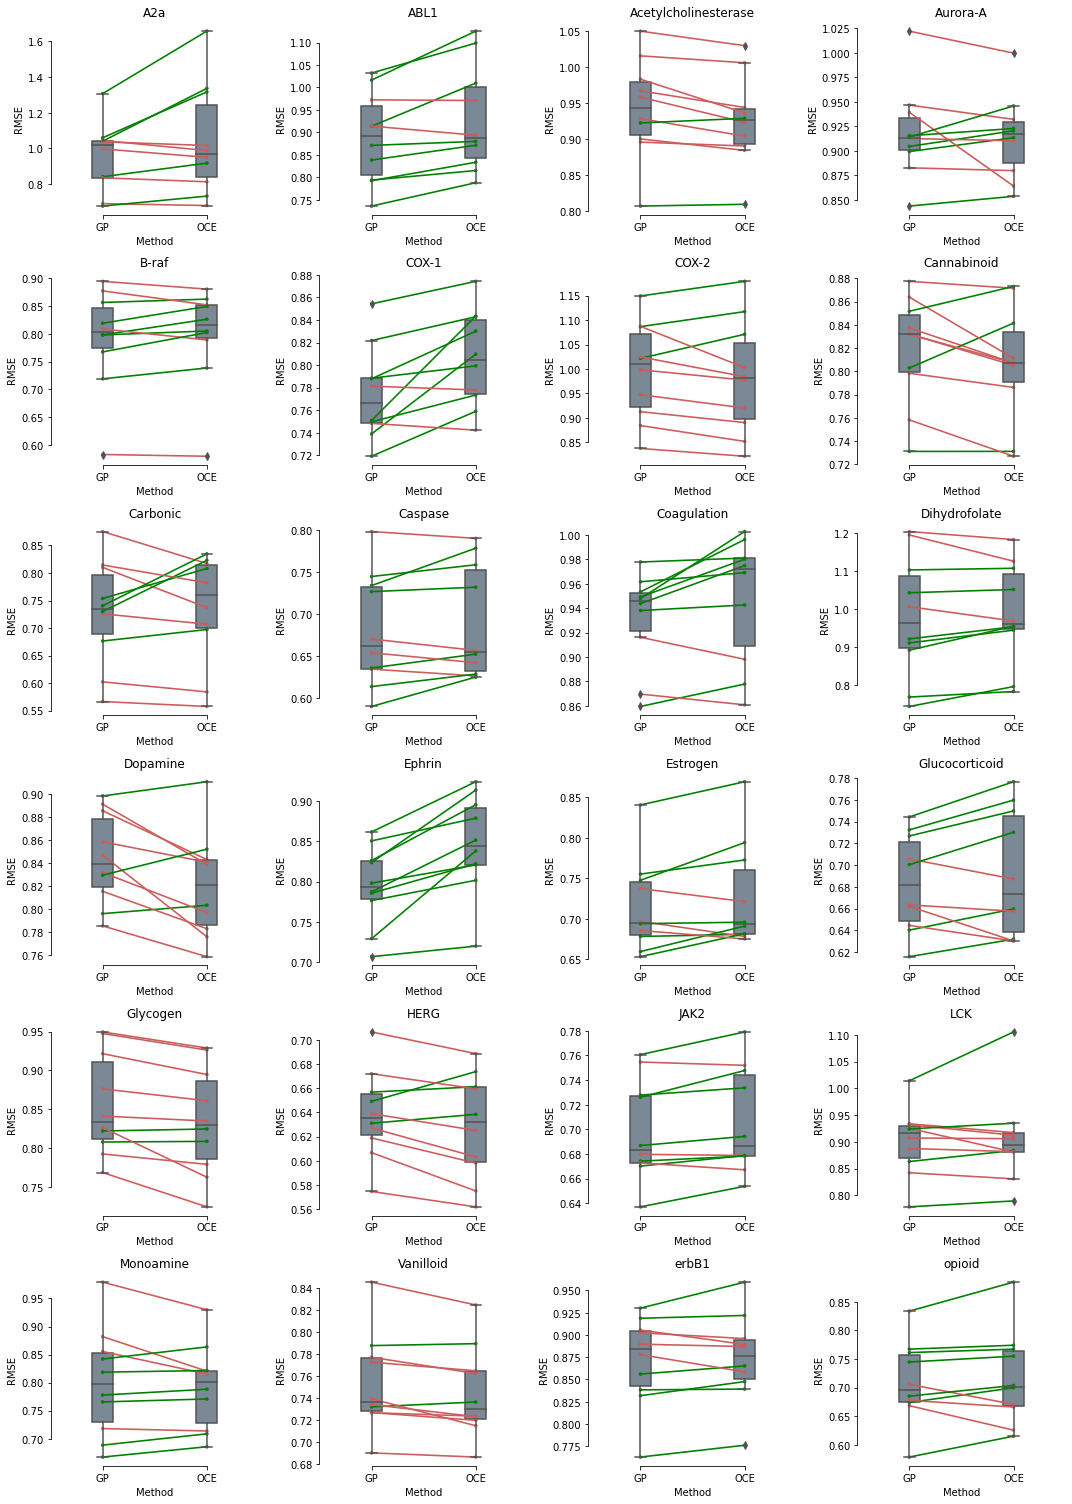

In [26]:
fig, axs = plt.subplots(nrows=6,ncols=4,figsize=(15,21))
for idx,ds in enumerate(sorted(melt_df.dataset.unique())):
    row = idx//4
    col = idx%4
    ax = plot_paired(data=melt_df.query("dataset == @ds"),dv="value",within="variable",subject="cycle",ax=axs[row,col])
    ax.set_title(ds)
    ax.set_ylabel("RMSE")
    ax.set_xlabel("Method")
    plt.tight_layout()